### Package Imports

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np
import math
import time
import psutil

In [1]:
import keras
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU
from keras_tuner import Objective
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

C:\Users\Bavan\AppData\Local\Temp\ipykernel_16160\655868316.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [3]:
default_freq = 'H'

### Data retrieval from GitHub

In [7]:
local_base_dir = '../../data'
data = {}

def addFolderAndReadAll(d_name):
    data[d_name] = {}
    folder_path = os.path.join(local_base_dir, d_name)
    
    if not os.path.exists(folder_path):
        print(f"Directory {folder_path} does not exist.")
        return 0

    csv_files = [f_name for f_name in os.listdir(folder_path) if f_name.endswith('.csv')]
    csvs_num = 0
    for f_name in csv_files:
        file_path = os.path.join(folder_path, f_name)
        df = pd.read_csv(file_path)
        data[d_name][f_name] = df
        csvs_num += 1
    return csvs_num

directories = ["artificialWithAnomaly", "artificialNoAnomaly", "realAdExchange", "realAWSCloudwatch", "realKnownCause", "realTraffic", "realTweets"]
csvs_num = sum([addFolderAndReadAll(d_name) for d_name in directories])

print(f"Total CSV files processed: {csvs_num}")


Total CSV files processed: 58


### Preprocessing

In [8]:
# Function to get a random start date from the DataFrame index
def get_random_start_date(index):
    return np.random.choice(index)

# Main function to repeat the process until non-None frequency is obtained
def find_non_none_frequency(df, offset=9):
    while True:
        # Get a random start date from the DataFrame index
        start_date = pd.to_datetime(get_random_start_date(df.index))

        # Find the index of the end date by moving 9 steps through the indices
        end_date_index = df.index.get_loc(start_date) + offset

        # Check if the end date index is within the range of the DataFrame index
        if end_date_index < len(df.index):
            # Calculate the end date using the index
            end_date = df.index[end_date_index]

            # Infer frequency within the specified date range
            subset_df = df.loc[start_date:end_date]
            freq = pd.infer_freq(subset_df.index)

            if freq is not None:
                print("Inferred frequency within range", start_date, "-", end_date, ":", freq)
                return freq  # Exit the loop and return the inferred frequency

In [9]:
def max_consecutive_missing_dates(inferred_freq, missing_dates):
    # Function to check if two dates are consecutive based on the inferred frequency
    def are_consecutive(date1, date2, freq):
        # Calculate the difference between dates based on the inferred frequency
        diff = date2 - date1
        # Check if the difference matches the frequency
        if freq == 'D':
            return diff.days == 1
        elif freq.endswith('H')| freq.endswith('h'):
             # If the frequency ends with 'H', check if it represents hourly intervals
            if freq[:-1]:  # Check if there is a multiplier
                  interval = int(freq[:-1])
                  return diff.total_seconds() == interval * 3600
            else:
                   # If no multiplier is provided, it's assumed to be one hour
                   return diff.total_seconds() == 3600
        elif freq.endswith('T') | freq.endswith('min') :
            if freq.endswith('T'):
                # Extract the interval from the frequency string
                interval = int(freq[:-1])
                return diff.seconds // 60 == interval
            else:
                interval = int(freq[:-3])
                return diff.seconds // 60 == interval
        else:
            raise ValueError("Unsupported frequency: {}".format(freq))

    # Initialize variables to track maximum length and current length
    max_consecutive_missing = 0
    current_consecutive_missing = 0

    # Iterate over the missing dates
    for i in range(1, len(missing_dates)):
        # Check if the current date is consecutive with the previous date
        if are_consecutive(missing_dates[i - 1], missing_dates[i], inferred_freq):
            # Increment current consecutive missing count
            current_consecutive_missing += 1
        else:
            # Update maximum consecutive missing count if needed
            max_consecutive_missing = max(max_consecutive_missing, current_consecutive_missing)
            # Reset current consecutive missing count
            current_consecutive_missing = 0

    # Update max_consecutive_missing if current_consecutive_missing is still greater
    max_consecutive_missing = max(max_consecutive_missing, current_consecutive_missing)

    return max_consecutive_missing

In [10]:
def preprocess(df, f_name):
    # Convert 'timestamp' column to datetime format and rename it to 'ds'
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Removing the duplicate rows
    df = df[~df.duplicated(keep='first')]

    duplicated_dates_length = len(df[df['timestamp'].duplicated(keep=False)])

    if  duplicated_dates_length > 0:
      print("Number of Duplicated Dates in "+ f_name + ": "+ str(duplicated_dates_length))
      # To make the mean as the value for the numerical columns if there are different values for a particular date
      df = df.groupby('timestamp').mean()
      # Reset index to bring 'timestamp' column back
      df.reset_index(inplace=True)

    df.set_index(['timestamp'], inplace=True)
    df.sort_index()

    # Create a date range with hourly frequency covering the entire time range
    start_date = df.index.min()
    end_date = df.index.max()

    #inferred_freq = pd.infer_freq(df.index)
    inferred_freq = find_non_none_frequency(df)

    if inferred_freq is None:
      inferred_freq = default_freq # setting the default frequency
      print("Cannot infer the frequency of the timestamp of the dataset "+ f_name+ " .Therefore the default frequency of " + default_freq+ " will be used")

    expected_date_range = pd.date_range(start=start_date, end=end_date, freq=inferred_freq)

    # Find the missing date entries
    missing_dates = expected_date_range[~expected_date_range.isin(df.index)]
    # Print or work with the list of missing dates
    print("Number of Missing Dates in "+ f_name + ": "+ str(len(missing_dates))+"\n")

    if len(missing_dates) > 0:
      df = df.asfreq(inferred_freq)
      df.sort_index()

      # Call the function with inferred_freq and missing_dates parameters
      max_consecutive = max_consecutive_missing_dates(inferred_freq, missing_dates)
      print("Maximum length of consecutive missing dates:", max_consecutive)
      if max_consecutive > 3:
        print("It is better to use other imputation method rather than linear interpolation")

      df['value'] = df['value'].interpolate(method='linear')

    return df

### Adding directories and iterations of above functions

In [11]:
# List of directories
dirs = ['realAdExchange', 'realAWSCloudwatch', 'realKnownCause', 'realTweets', 'artificialWithAnomaly', 'artificialNoAnomaly']
#dirs = ['realAdExchange']
#dirs = ['artificialNoAnomaly']

# Loop through each directory
for dir in directories:
    for f_name in data[dir]:
        print("")
        print(f"Iterating over file: {dir} / {f_name}")
        df = preprocess(data[dir][f_name], f_name)


Iterating over file: artificialWithAnomaly / art_daily_flatmiddle.csv
Inferred frequency within range 2014-04-09 13:45:00 - 2014-04-09 14:30:00 : 5min
Number of Missing Dates in art_daily_flatmiddle.csv: 0


Iterating over file: artificialWithAnomaly / art_daily_jumpsdown.csv
Inferred frequency within range 2014-04-07 20:55:00 - 2014-04-07 21:40:00 : 5min
Number of Missing Dates in art_daily_jumpsdown.csv: 0


Iterating over file: artificialWithAnomaly / art_daily_jumpsup.csv
Inferred frequency within range 2014-04-06 18:05:00 - 2014-04-06 18:50:00 : 5min
Number of Missing Dates in art_daily_jumpsup.csv: 0


Iterating over file: artificialWithAnomaly / art_daily_nojump.csv
Inferred frequency within range 2014-04-10 08:50:00 - 2014-04-10 09:35:00 : 5min
Number of Missing Dates in art_daily_nojump.csv: 0


Iterating over file: artificialWithAnomaly / art_increase_spike_density.csv
Inferred frequency within range 2014-04-05 03:50:00 - 2014-04-05 04:35:00 : 5min
Number of Missing Dates in

### General functions for model training

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [13]:
def split_data(df, train_size=0.6):
    # Calculate the number of days for training data based on the specified train_size
    train_len = math.floor(len(df) * train_size)

    # Split the dataframe into training and testing data based on the calculated train_days
    train_data, test_data = df[0:train_len, :], df[train_len:len(df), :]

    # Return the training and testing data
    return train_data, test_data

In [24]:
from statsmodels.tsa.stattools import acf
from scipy.stats import norm

def find_optimal_lookback(df, max_lookback=20, confidence_level=0.95):
    # Calculate autocorrelation
    acf_values = acf(df, nlags=max_lookback, fft=False)

    # Calculate significance threshold using Bonferroni correction
    n_obs = len(df)
    alpha = 1 - confidence_level
    significance_threshold = norm.ppf(1 - alpha / (2 * (max_lookback + 1) + 2 / np.sqrt(n_obs)))

    # Find significant lags
    significant_lags = np.where(np.abs(acf_values[1:]) > significance_threshold)[0]

    # Choose the optimal lag based on certain criteria
    if len(significant_lags) > 0:
        # For example, choose the lag with the maximum autocorrelation
        look_back = np.argmax(np.abs(acf_values[significant_lags])) + 1
    else:
        # If no significant lags found, default to max_lags
        look_back = max_lookback

    print(f"Optimal lookback: {look_back}")
    return look_back

In [14]:
def scale_data(df):
    df_normalized = scaler.fit_transform(df)
    return df_normalized

In [15]:
def create_dataset(df, look_back):
    X, Y = list(), list()
    for i in range(len(df) - look_back - 1):
        a = df[i:(i + look_back), 0]
        X.append(a)
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [16]:
def build_GRU_model(hp):
    model = Sequential()

    # Tune the number of units in the first GRU layer
    model.add(GRU(units=hp.Int('units_1', min_value=32, max_value=128, step=16),
                  return_sequences=True,
                  input_shape=(trainX.shape[1], trainX.shape[2])))

    # Tune the number of units in the second GRU layer
    model.add(GRU(units=hp.Int('units_2', min_value=16, max_value=64, step=16),
                  return_sequences=True))

    # Tune the number of units in the third GRU layer
    model.add(GRU(units=hp.Int('units_3', min_value=16, max_value=64, step=16)))

    # Dense layer with 1 unit
    model.add(Dense(units=1))

    # Tune the learning rate of the optimizer
    model.compile(loss='mae',
                  optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  metrics=['mae', 'mape'])
    
    return model

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3, mode='min', verbose=1)

In [18]:
def find_best_model(tuner, trainX, Y_train, testX, Y_test):
    tuner.search(
        x=trainX,
        y=Y_train,
        epochs=50,
        batch_size=16,
        callbacks=[early_stopping]
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    return best_model

In [19]:
def find_metrics(testPredict, Y_test):
    # invert predictions
    testPredict = scaler.inverse_transform(testPredict)

    testY = scaler.inverse_transform([Y_test])

    testMAE = mean_absolute_error(testY[0], testPredict[:,0])
    testMAPE = mean_absolute_percentage_error(testY[0], testPredict[:,0])
    print('Test Score: MAE %.2f' % (testMAE))
    
    return testMAE, testMAPE

In [20]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt

def plot_results(df, look_back, Y_train, testPredict, model, f_name):
    # Create the directory if it does not exist
    output_dir = os.path.join('../../visualization', model)
    os.makedirs(output_dir, exist_ok=True)
    
    # Construct the output file path
    output_file = os.path.join(output_dir, f"{model}_{f_name}.png")
    
    # Check if the file already exists
    if os.path.exists(output_file):
        # If the file exists, remove it
        os.remove(output_file)
        print(f"Existing plot file '{output_file}' removed.")
        
    # Calculate the start and end indices for the test range
    test_start_idx = len(Y_train) + (look_back * 2) + 1
    test_end_idx = len(df) - 1

    # Shift test predictions for plottin+g
    testPredictPlot = np.empty((test_end_idx - test_start_idx, 1))
    testPredictPlot[:, :] = np.nan
    testPredictPlot[:testPredict.shape[0], :] = testPredict

    # Plot baseline and predictions
    plt.figure(figsize=(20, 8))

    # Plot only the test data and predictions for test data
    plt.plot(range(test_start_idx, test_end_idx), df[test_start_idx:test_end_idx], label="Test Data")
    plt.plot(range(test_start_idx-1, test_start_idx + testPredict.shape[0]-1), testPredictPlot, label="Test Predictions")
    
    # Add legend, axis labels, and title
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f"{model} / {f_name}")

    # Save Matplotlib figure as PNG
    plt.savefig(output_file)
    #plt.close(plt)
    print(f"Matplotlib PNG plot saved as '{output_file}'")
    
    plt.show()

In [21]:
def delete_tuner():
    # Specify the path to the tuner0.json file
    file_path = './untitled_project/tuner0.json'

    # Check if the file exists before attempting to delete it
    if os.path.exists(file_path):
        # Attempt to delete the file
        os.remove(file_path)
        print(f"File {file_path} has been deleted.")
    else:
        print(f"File {file_path} does not exist.")

In [22]:
def save_data(prediction_deep_data, mae_deep_data, results_table):
    # Convert collected data into DataFrames
    table1_df = pd.DataFrame(prediction_deep_data)
    table2_df = pd.DataFrame(mae_deep_data)
    results_df = pd.DataFrame(results_table)

    # Specify the folder to save CSV files
    output_folder = "../../dataset_preparation"

    # Save tables as CSV files
    table1_df.to_csv(os.path.join(output_folder, 'GRU_prediction.csv'), index=False)
    table2_df.to_csv(os.path.join(output_folder, 'GRU_mae.csv'), index=False)
    results_df.to_csv(os.path.join(output_folder, 'GRU_results.csv'), index=False)

In [22]:
# Create lists to store data for both tables
GRU_results_data = []
GRU_prediction_data = []
GRU_mae_data = []
GRU_mape_data = []

Trial 10 Complete [00h 00m 07s]
mae: 0.0831579938530922

Best mae So Far: 0.0831422209739685
Total elapsed time: 00h 01m 06s
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
Test Score: MAE 0.21
Matplotlib PNG plot saved as '../visualization2\GRU\GRU_rds_cpu_utilization_cc0c53.csv.png'


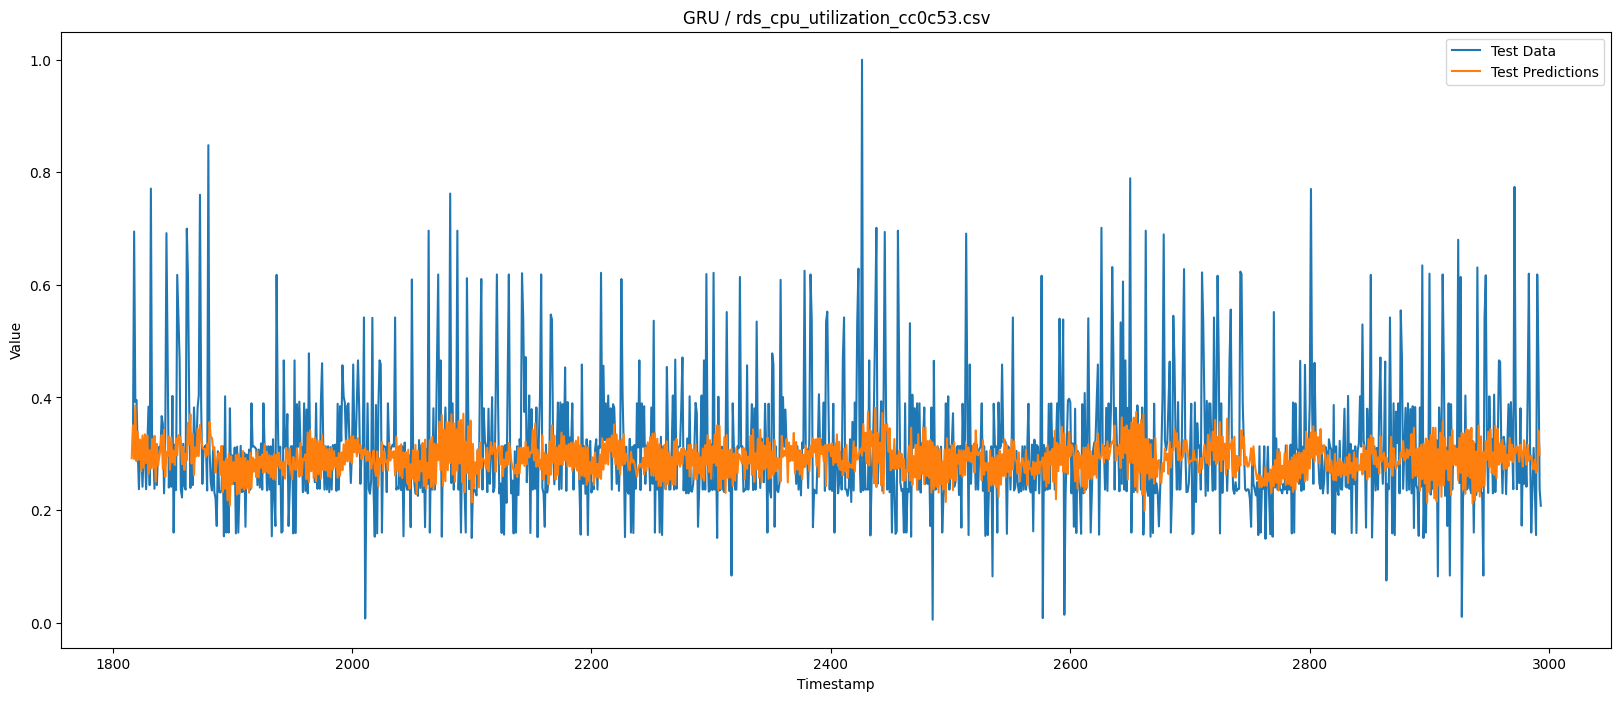

File ./untitled_project/tuner0.json has been deleted.


In [25]:
for dir in directories:
    for f_name in data[dir]:
        print("")
        print(f"Iterating over file: {f_name}")
        df = data[dir][f_name]

        df = df['value'].values.reshape(-1, 1)
        df = df.astype('float32')

        df = scale_data(df)
        
        look_back = find_optimal_lookback(df)

        # Split the data into training and testing sets
        train_data, test_data = split_data(df)

        X_train,Y_train=create_dataset(train_data,look_back)
        X_test,Y_test=create_dataset(test_data,look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        tuner = BayesianOptimization(
            build_GRU_model,
            objective=Objective('mae', direction='min'),
            max_trials=10,
            num_initial_points=None,
            alpha=0.0001,
            beta=2.6,
            seed=None,
            hyperparameters=None,
            tune_new_entries=True,
            allow_new_entries=True,
            max_retries_per_trial=0,
            max_consecutive_failed_trials=3
        )

        best_model = find_best_model(tuner, trainX, Y_train, testX, Y_test)

        # make predictions
        testPredict = best_model.predict(testX)
        test_mae, test_mape = find_metrics(testPredict, Y_test)

        # Append results to the main results table
        GRU_results_data.append({
            'Model Name': 'GRU',
            'File Name': f_name,
            'GRU_MAE': test_mae,
            'Model Parameters': best_model.get_config()
        })

        # Collect data for table 1
        GRU_prediction_data.append({
            'dir': dir,
            'file_name': f_name,
            'original_values': Y_test.tolist(),
            'predicted_values': testPredict.tolist()
        })

        GRU_mae_data.append({
            'dir': dir,
            'file_name': f_name,
            'GRU_mae': test_mae
        })
        
        GRU_mape_data.append({
            'file_name': f_name,
            'GRU_mape': test_mape
        })

        plot_results(df, look_back, Y_train, testPredict, 'GRU' , f_name)

        delete_tuner()

In [26]:
# Convert collected data into DataFrames
GRU_results = pd.DataFrame(GRU_results_data)
GRU_predictions = pd.DataFrame(GRU_prediction_data)
GRU_mae = pd.DataFrame(GRU_mae_data)
GRU_mape = pd.DataFrame(GRU_mape_data)

# Specify the folder to save CSV files
output_folder = "../../dataset_preparation"

# Create the directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Save tables as CSV files
GRU_results.to_csv(os.path.join(output_folder, 'GRU_results.csv'), index=False)
GRU_predictions.to_csv(os.path.join(output_folder, 'GRU_predictions.csv'), index=False)
GRU_mae.to_csv(os.path.join(output_folder, 'GRU_mae.csv'), index=False)
GRU_mape.to_csv(os.path.join(output_folder, 'GRU_mape.csv'), index=False)

### Create model for dataset

In [ ]:
def create_GRU_model(df):
    Testdata_GRU_predictions = []
    df = df['value'].values.reshape(-1, 1)
    df = df.astype('float32')

    df = scale_data(df)
    
    look_back = find_optimal_lookback(df)

    # Split the data into training and testing sets
    train_data, test_data = split_data(df)

    X_train,Y_train=create_dataset(train_data,look_back)
    X_test,Y_test=create_dataset(test_data,look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    tuner = BayesianOptimization(
        build_GRU_model,
        objective=Objective('mae', direction='min'),
        max_trials=10,
        num_initial_points=None,
        alpha=0.0001,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3
    )

    best_model = find_best_model(tuner, trainX, Y_train)

    # make predictions
    testPredict = best_model.predict(testX)

    # Collect data for table
    Testdata_GRU_predictions.append({
        'dir': dir,
        'file_name': f_name,
        'original_values': Y_test.tolist(),
        'predicted_values': testPredict.tolist()
    })

    GRU_predictions = pd.DataFrame(Testdata_GRU_predictions)

    # Specify the folder to save CSV files
    output_folder = "../../testdata_predictions"

    # Create the directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Save table as CSV files
    GRU_predictions.to_csv(os.path.join(output_folder, 'GRU_predictions.csv'), index=False)

    # Create the directory if it does not exist
    model_directory = os.path.join("../../model_pickle/base_models")

    # Construct the file path
    GRU_filename = os.path.join(model_directory, "GRU_model.pkl")

    # Delete the files if they already exist
    if os.path.exists(GRU_filename):
        os.remove(GRU_filename)

    with open(GRU_filename, 'wb') as f:
        pickle.dump(best_model, f)

# Don't Change

In [21]:
results_table = []
prediction_deep_data = []
mae_deep_data = []

In [26]:
look_back = 5

for dir in directories:
  for f_name in data[dir]:
        print("")
        print(f"Iterating over file: {dir} / {f_name}")
        df = data[dir][f_name]

        df = df['value'].values.reshape(-1, 1)
        df = df.astype('float32')

        df = scale_data(df)

        # Split the data into training and testing sets
        train_data, test_data = split_data(df)

        X_train,Y_train=create_dataset(train_data,look_back)
        X_test,Y_test=create_dataset(test_data,look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        start_time = time.time()
        start_cpu = psutil.cpu_percent()
        start_memory = psutil.virtual_memory().used

        tuner = BayesianOptimization(
            build_GRU_model,
            objective=Objective('mae', direction='min'),
            max_trials=10,
            num_initial_points=None,
            alpha=0.0001,
            beta=2.6,
            seed=None,
            hyperparameters=None,
            tune_new_entries=True,
            allow_new_entries=True,
            max_retries_per_trial=0,
            max_consecutive_failed_trials=3
        )

        best_model = find_best_model(tuner, trainX, Y_train, testX, Y_test)

        # make predictions
        trainPredict = best_model.predict(trainX)
        testPredict = best_model.predict(testX)

        train_mae, test_mae = find_mae(trainPredict, testPredict, Y_train, Y_test)

        # Append results to the table
        results_table.append({
            'Model Name': 'GRU',
            'File Name': f_name,
            'Train RMSE': train_mae,
            'Test RMSE': test_mae,
            'Model Parameters': best_model.get_config()
        })

        # Collect data for table 1
        prediction_deep_data.append({
            'dir': dir,
            'file_name': f_name,
            'original_values': Y_test.tolist(),
            'predicted_values': testPredict.tolist()
        })

        mae_deep_data.append({
            'dir': dir,
            'file_name': f_name,
            'lstm_mae': test_mae
        })

        save_data(prediction_deep_data, mae_deep_data, results_table)

        plot_results(df, look_back, trainPredict, testPredict, 'GRU', f_name)

        delete_tuner()

Trial 10 Complete [00h 07m 41s]
mae: 0.002290722681209445

Best mae So Far: 0.00223340280354023
Total elapsed time: 01h 17m 59s
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train Score: MAE 29.03
Test Score: MAE 33.12
Existing plot file '../visualization\GRU\GRU_Twitter_volume_AAPL.csv.png' removed.
File ./untitled_project/tuner0.json has been deleted.

Iterating over file: realTweets / Twitter_volume_AMZN.csv

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
80                |80                |units_1
48                |48                |units_2
48                |48                |units_3
adam              |adam              |optimizer

Epoch 1/20
663/663 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - mae: 0.0089

In [33]:
look_back = 5
results_table = []

for dir in directories:
  for f_name in data[dir]:
        print("")
        print(f"Iterating over file: {dir} / {f_name}")
        df = data[dir][f_name]

        mae_result = {'dir': dir, 'file_name': f_name}
        cpu_results = {'dir': dir, 'file_name': f_name}
        memory_results = {'dir': dir, 'file_name': f_name}
        time_results = {'dir': dir, 'file_name': f_name}

        df = df['value'].values.reshape(-1, 1)
        df = df.astype('float32')

        df = scale_data(df)

        # Split the data into training and testing sets
        train_data, test_data = split_data(df)

        X_train,Y_train=create_dataset(train_data,look_back)
        X_test,Y_test=create_dataset(test_data,look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

        start_time = time.time()
        start_cpu = psutil.cpu_percent()
        start_memory = psutil.virtual_memory().used

        tuner = BayesianOptimization(
            build_GRU_model,
            objective=Objective('mae', direction='min'),
            max_trials=10,
            num_initial_points=None,
            alpha=0.0001,
            beta=2.6,
            seed=None,
            hyperparameters=None,
            tune_new_entries=True,
            allow_new_entries=True,
            max_retries_per_trial=0,
            max_consecutive_failed_trials=3
        )

        best_model = find_best_model(tuner, trainX, Y_train, testX, Y_test)

        # make predictions
        trainPredict = best_model.predict(trainX)
        testPredict = best_model.predict(testX)

        train_mae, test_mae = find_mae(trainPredict, testPredict, Y_train, Y_test)

        end_time = time.time()
        end_cpu = psutil.cpu_percent()
        end_memory = psutil.virtual_memory().used

        elapsed_time = end_time - start_time
        cpu_usage = end_cpu - start_cpu
        memory_usage = end_memory - start_memory

        print("Time taken:", elapsed_time, "seconds")
        print("CPU Usage:", cpu_usage, "%")
        print("Memory Usage:", memory_usage, "bytes")

        mae_result['GRU'] = train_mae
        cpu_results['GRU'] = cpu_usage
        memory_results['GRU'] = memory_usage
        time_results['GRU'] = elapsed_time

        # Append results to the table
        results_table.append({
            'Model Name': 'GRU',
            'File Name': f_name,
            'Train RMAE': train_mae,
            'Test RMAE': test_mae,
            'Model Parameters': best_model.get_config()
        })

        plot_results(df, look_back, trainPredict, testPredict, 'GRU', f_name)

        delete_tuner()

Trial 10 Complete [00h 00m 28s]
mae: 0.32988882064819336

Best mae So Far: 0.329507052898407
Total elapsed time: 00h 06m 43s
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: MAE 36.11
Test Score: MAE 44.41
Time taken: 419.8688373565674 seconds
CPU Usage: -4.9 %
Memory Usage: -190382080 bytes


ValueError: could not broadcast input array from shape (2695,1,1) into shape (2695,1)